## Setup

In [15]:
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import PointDataset

from models.unet_model import UNET


In [16]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

# Splitting into training and validation
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)

In [21]:
# Creating the dataset
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps[:2], y_train_fps[:2], augmentation=train_augmentation, preprocessing=preprocessing_fn, concat_heatmap=False)
val_dataset  = PointDataset(x_val_fps[:2], y_val_fps[:2], augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=False)

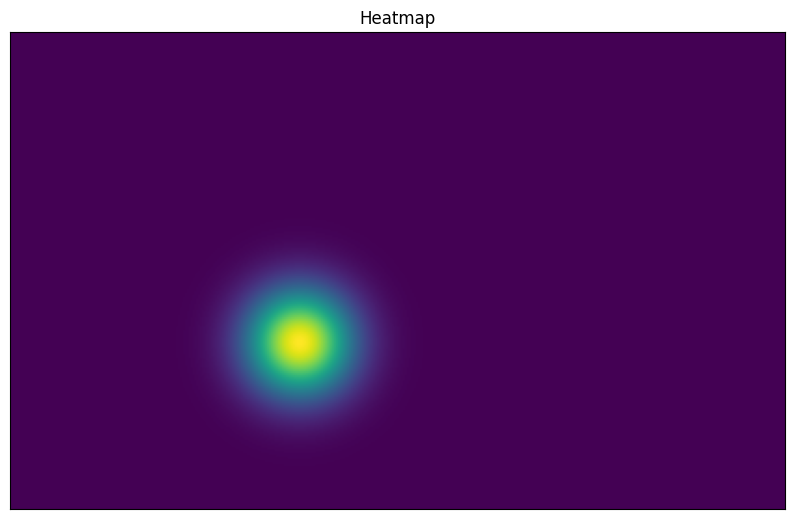

In [22]:
from segmentation.show import *
image, mask, heatmap = train_dataset[1]
visualise_data(heatmap = heatmap)

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_fn(loader, model, optimizer, loss_fn, scaler):
    '''
    One epoch of training
    '''
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE,  dtype=torch.float32)
        targets = targets.long().unsqueeze(1).to(device = DEVICE)

        # forward
        with torch.autocast(device_type=DEVICE, dtype=torch.float16):
            targets = targets.to(device = DEVICE).squeeze(1)  # Now masks is (N,H,W)
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss = loss.item())

def validate_fn(loader, model, loss_fn):
    model.eval()  # set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device=DEVICE, dtype=torch.float32)
            targets = targets.long().unsqueeze(1).to(device=DEVICE)
            with torch.autocast(device_type=DEVICE, dtype=torch.float16):
                # squeeze targets to get shape (N, H, W)
                predictions = model(data)
                loss = loss_fn(predictions, targets.squeeze(1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    model.train()  # set model back to training mode
    return avg_loss


def train_and_evaluate(model, optimizer, train_loader, valid_loader, loss_fn, scaler, num_epochs):
    '''
    Trains the model for a given set of hyperparameters and evaluates it.
    '''
    best_val_loss = 0

    for epoch in range(num_epochs):
        # ... training loop ....
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        checkpoint = {'state_dict': model.state_dict()}

        val_loss = validate_fn(valid_loader, model, loss_fn)
        print(f'validation loss: {val_loss}')

        # Saving if the validation loss is better
        if val_loss > best_val_loss:
            model_utils.save_checkpoint(checkpoint)
            best_val_loss = val_loss


    



In [ ]:
model = UNET(in_channels=4, out_channels=3).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = amp.GradScaler()

train_and_evaluate(model=model,
                   optimizer=optimizer,
                   train_loader=train_loader,
                   valid_loader=val_loader,
                   loss_fn= loss_fn,
                   scaler=scaler,
                   num_epochs=5
                   )

  0%|          | 0/368 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/miniconda3/envs/cv/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/cv/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
  0%|          | 0/368 [00:01<?, ?it/s]    self = reduction.pickle.load(from_parent)

           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/dataset.py", line 6, in <module>
    import albumentations as albu
  File "/opt/miniconda3/envs/cv/lib/python3.12/site-packages/albumentations/__init__.py", line 28, in <module>
    check_for_updates()
  File "/opt/miniconda3/envs/cv/lib/python3.12/site-packages/albumentations/check_version.py", line 107, in check_for_update

KeyboardInterrupt: 